# BBC news classfication

### Contents
1. Loarding data and cleaning
2. Observation of training dataset
3. Build unsupervised model
4. Compare to supervised learning
5. Compare the results of BBC News test dataset(unlabled) with the result of unsupervised and supervised learning
6. Conclusion
---

### 1. Loarding data and cleaning

This is the sentences of news ariticles of BBC and it's genre datasets. First we import libraries and looading the datasets from csv files.

In [18]:
# import libraries
from itertools import permutations
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
from collections import defaultdict
from sklearn.decomposition import NMF

In [19]:
# import the training data
train_data = pd.read_csv('BBC News Train.csv')
train_text = train_data['Text']
train_label = train_data['Category']

# import the test data
test_text = pd.read_csv('BBC News Test.csv')['Text']

**1-1. How much data do we have?**

In [20]:
print(f'The train dataset has {len(train_data)} rows and the test dataset has {len(test_text)} rows')

The train dataset has 1490 rows and the test dataset has 735 rows


**1-2. Show train and test 5 head texts**

In [21]:
print('The first 5 rows of the train dataset are:')
print(train_text[:5])
print('The first 5 rows of the test dataset are:')
print(test_text[:5])

The first 5 rows of the train dataset are:
0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle  governs mobile choice  faster  bett...
4    enron bosses in $168m payout eighteen former e...
Name: Text, dtype: object
The first 5 rows of the test dataset are:
0    qpr keeper day heads for preston queens park r...
1    software watching while you work software that...
2    d arcy injury adds to ireland woe gordon d arc...
3    india s reliance family feud heats up the ongo...
4    boro suffer morrison injury blow middlesbrough...
Name: Text, dtype: object


**1-3. Data cleaning**

There is missspelling in the code such as 'qpr' and also there is various form of the same word such as 'lawyers' and 'lawyer'.

In this proccess, we remove the 'stop words' which are common words that appear in the all topics such as 'the', 'is', and so on.

They affect the accuracy of the model.

So let's clean the data by replacing the missspelling and also convert the words to their base form using the remmaization technique.

In [6]:
i=0
length = len(train_text) + len(test_text)

def correct_and_lemmatize(text):
    # initialize the spell checker, lemmatizer and stopwords
    spell = SpellChecker()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text.lower())
    # correct the spelling of the words
    corrected_words = [spell.correction(word) if spell.correction(word) else word for word in words]
    # lemmatize the words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in corrected_words if word.isalpha() and word not in stop_words]

    global i
    i += 1
    print(f'{i}/{length}')
    return ' '.join(lemmatized_words)

# apply the function to the train and test all rows
train_text = train_text.apply(correct_and_lemmatize)
test_text = test_text.apply(correct_and_lemmatize)

**1-4. Save the cleanied text to a new csv file**

In the data cleaning process, The runtime of the code of above is too long. So I need to save the text to a nes csv files.

In [43]:
# train_text.to_csv('cleaned BBC News Train.csv', index=False)
# test_text.to_csv('cleaned BBC News Test.csv', index=False)

---
### 2. Observation of training dataset
In this section, we will observe the training dataset. How much topics are there, which word is most frequent for each topic and so on.

**2-1. What potics(label) are in the dataset**

In [22]:
# load the cleaned trining data
train_text = pd.read_csv('cleaned BBC News Train.csv')['Text']
topics = set(train_label)
topics

{'business', 'entertainment', 'politics', 'sport', 'tech'}

**2-2. How many articles are in the training for each topic?**

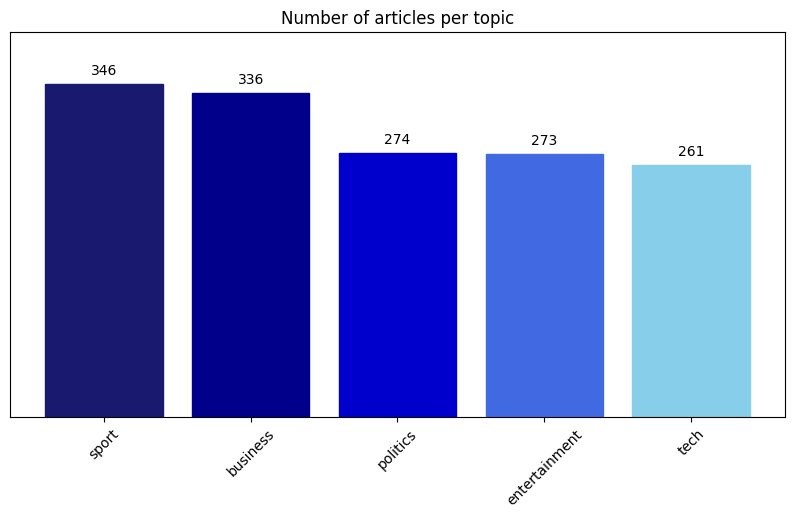

In [23]:
lable_list = train_label.tolist()

# count the number of times each topic appears
topic_counts = {topic: lable_list.count(topic) for topic in topics}

# order the topics by count descending
topic_counts = dict(sorted(topic_counts.items(), key=lambda item: item[1], reverse=True))

# make barchart of topic counts
plt.figure(figsize=(10, 5))
plt.bar(topic_counts.keys(), topic_counts.values())
# map the colors to the topics(dark blue to the sky blue by gradient)
colors = [ 'MidnightBlue','DarkBlue', 'MediumBlue', 'RoyalBlue', 'SkyBlue']
for i, bar in enumerate(plt.gca().patches):
    bar.set_color(colors[i])
# rotate the x axis labels
plt.xticks(rotation=45)
plt.title('Number of articles per topic')
# show each bar value
for i, v in enumerate(topic_counts.values()):
    plt.text(i, v + 10, str(v), ha='center')
# set the y axis max range to 400
plt.ylim(0, 400)
# delete y axis label
plt.yticks([])

plt.show()

**2-3 Which words are most frequent for each topic?**

Using TF-IDF algoritm to find the most frequent words for each topic.

 TF-IDF（Term Frequency - Inverse Document Frequency）is mothod to evalute importance of words in a document.

TF = Number of times a term appears in a document / Total number of terms in the document

IDF = log(Total number of documents / Number of documents with a term in it

TF-IDF = TF maliply IDF

So let's find the most frequent words for each topic and make visualization.

defaultdict(<class 'list'>, {'business': [('said', 10.174824369035713), ('firm', 9.550549934678743), ('company', 9.431089275772592), ('market', 8.87424861780878), ('year', 8.158507078430231), ('share', 7.442106442570499), ('growth', 7.440341349126283), ('economy', 7.10454849638194), ('bank', 7.057782026909161), ('analyst', 6.616746742487577)], 'tech': [('people', 7.70994273988787), ('user', 7.146311079957147), ('technology', 7.005090608128751), ('said', 6.285469100585849), ('computer', 6.156177823127674), ('software', 6.147736743755527), ('mobile', 5.755815122213026), ('service', 5.693454462357922), ('phone', 5.688600260715404), ('use', 5.357625301421378)], 'politics': [('labor', 9.784133638072957), ('election', 9.725463472759635), ('party', 8.776578937124405), ('minister', 8.673450453598903), ('government', 8.670692736831846), ('said', 8.503389633407913), ('flair', 8.475717948857415), ('plan', 6.108004845241691), ('say', 5.771318004074806), ('prime minister', 5.699283713691339)], 'spo

C:\Users\s-ohn\AppData\Local\Temp\ipykernel_15800\798993438.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=[word[0] for word in words], x=[word[1] for word in words], palette='viridis')


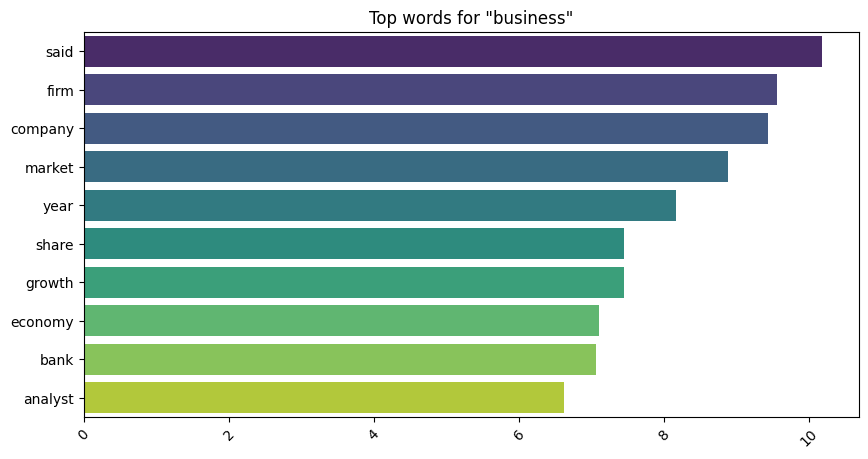

C:\Users\s-ohn\AppData\Local\Temp\ipykernel_15800\798993438.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=[word[0] for word in words], x=[word[1] for word in words], palette='viridis')


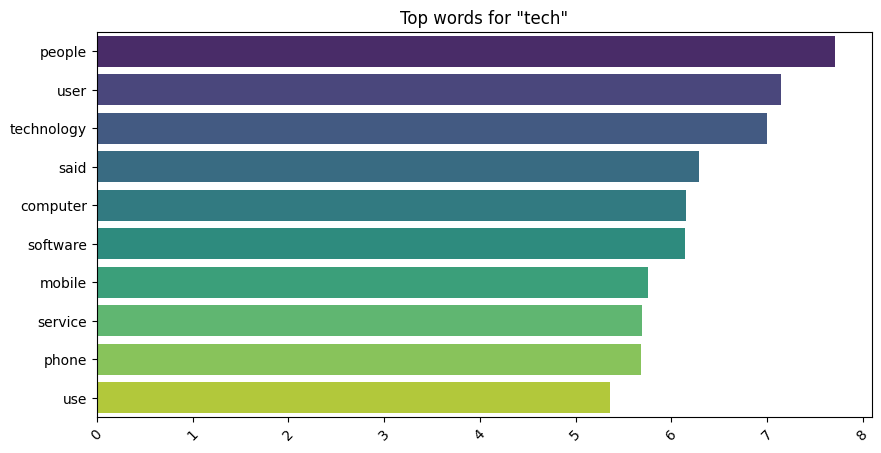

C:\Users\s-ohn\AppData\Local\Temp\ipykernel_15800\798993438.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=[word[0] for word in words], x=[word[1] for word in words], palette='viridis')


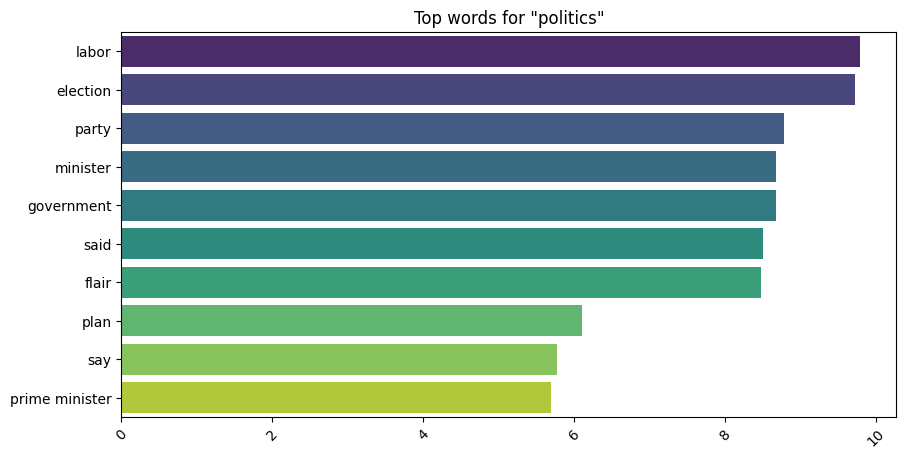

C:\Users\s-ohn\AppData\Local\Temp\ipykernel_15800\798993438.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=[word[0] for word in words], x=[word[1] for word in words], palette='viridis')


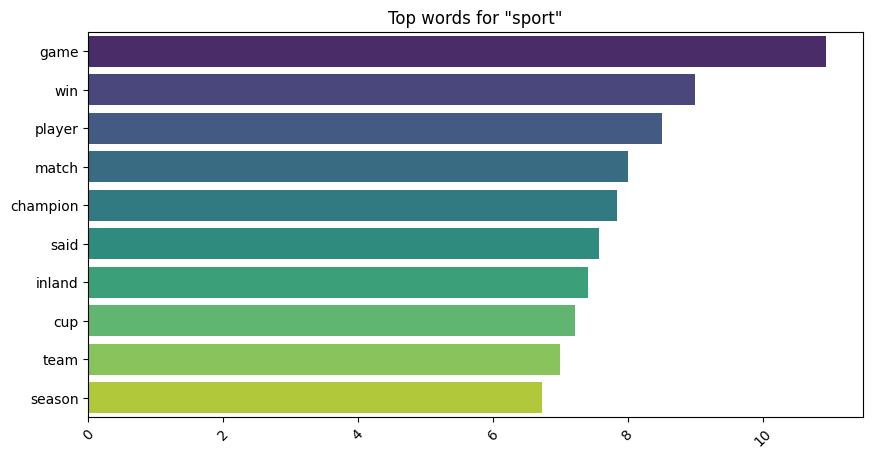

C:\Users\s-ohn\AppData\Local\Temp\ipykernel_15800\798993438.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=[word[0] for word in words], x=[word[1] for word in words], palette='viridis')


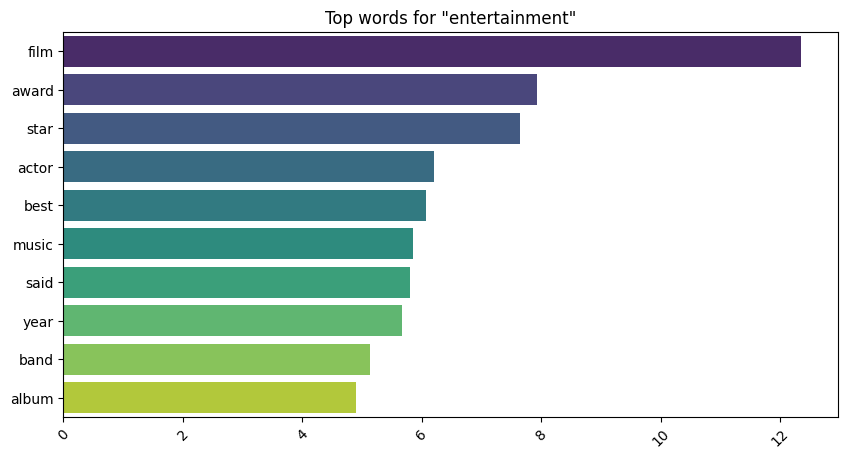

In [24]:
# TF-IDF vectorizer
vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2), stop_words='english', sublinear_tf=True)
X_tfidf = vectorizer.fit_transform(train_text)

top_words = defaultdict(list)
for category in train_label.unique():
    indices = train_label[train_label == category].index
    category_tfidf = X_tfidf[indices].sum(axis=0)
    sorted_indices = category_tfidf.argsort().tolist()[0][-10:]
    feature_names = vectorizer.get_feature_names_out()
    top_words[category] = [(feature_names[i], category_tfidf[0, i]) for i in reversed(sorted_indices)]

print(top_words)

for category, words in top_words.items():
    # make new figure
    plt.figure(figsize=(10, 5))
    # make a bar chart of the top words
    sns.barplot(y=[word[0] for word in words], x=[word[1] for word in words], palette='viridis')
    # change the color of the bars using color maps
    colors = plt.cm.viridis([word[1] for word in words])
    plt.xticks(rotation=45)
    plt.title(f'Top words for "{category}"')
    plt.show();

---
### 3. Unsupervised Learning with NMF
Using TF-IDF text data which has been enhanced important words, 
we can apply unsupervised learning to find the topics of the articles.
In this case, we will use Non-negative Matrix Factorization (NMF) to find the topics of the articles.

I think in unsupersised learning there is no need to split train and test dataset, because no label is given and the validation data is not requied.

NMF hepl us to find hiddenpatterns in the data and prodivde us feature matrix and the coefficient matrix.

First we assume that we do not know the number of topics in the articles and set the number of topics to default number of clusters 10. 

**3-1. Train the model using default number of clusters and make predictions**

In [25]:
# create a NMF model and fit it to the data
nmf = NMF(n_components=10, random_state=0)
nmf.fit(X_tfidf)

# predict the training data and get it's label
predict = nmf.transform(X_tfidf)
predict = np.argmax(predict, axis=1)

**3-2. Compare the predicted labels with the actual labels**

In [26]:
# function of making the matitrx of the predicted label and the true label using heatmap
def confusion_matrix_heatmap(true_label, predicted_label):
    confusion_matrix = pd.crosstab(true_label, predicted_label)
    plt.figure(figsize=(len(confusion_matrix.columns), len(confusion_matrix)))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='summer')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

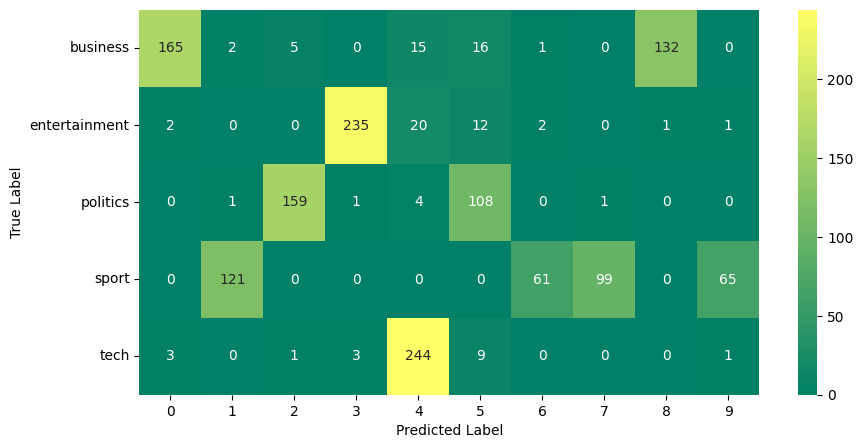

In [27]:
# Let's see the confusion matrix
confusion_matrix_heatmap(train_label, predict)

The result of clustering is interseting. The 'sport' category is divied into 4 clusters.
But the 'tech' is one cluster. What is this tell us? The result of this clustering help us to understand the new insight of the classification.For example, 'business' and 'politics' are similar in the context of the articles.

But now we can find a model which has correctly clustered lables.
Now let us change the number of components to 5 and see the result.

**3-3. Build a model with 5 number of clusters**

In [28]:
# change the numeric label to the original label
def change_label(predict, train_label):
    train_label_list = train_label.unique()
    best_accuracy = 0
    best_label = None
    for p in permutations(range(5)):
        new_label = predict.copy()
        for j, i in enumerate(p):
            if j == 0:
                new_label = np.where(new_label == j, train_label_list[i], new_label)
            else:
                new_label = np.where(new_label == str(j), train_label_list[i], new_label)
        accuracy = accuracy_score(train_label, new_label)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_label = new_label

    return best_label

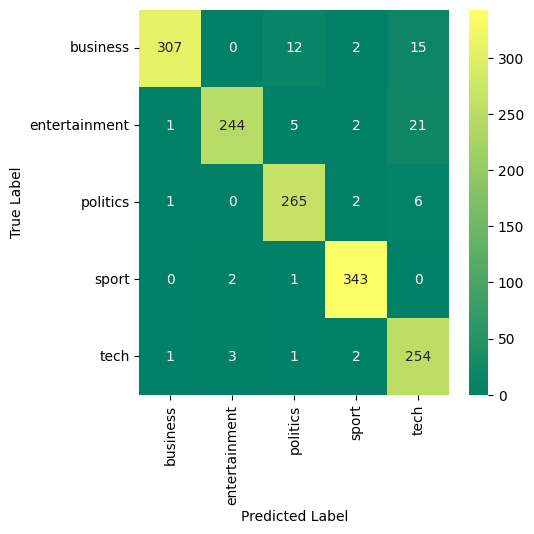

In [29]:
# create a NMF model and fit it to the data
nmf = NMF(n_components=5, random_state=0)
nmf.fit(X_tfidf)

# predict the training data and get it's label
predict = nmf.transform(X_tfidf)
predict = np.argmax(predict, axis=1)

# change the label of the predict to match the train_label
predict = change_label(predict, train_label)
#plot the confusion matrix
confusion_matrix_heatmap(train_label, predict)

**3-4. Check the accuracy of 5 cluster's model**

In [30]:
print(accuracy_score(train_label, predict))

0.9483221476510068


**3-5. find the best model**

So, we have tried the NMF model and it gave us an accuracy of 0.94. 
Now let's try change the parameters and how it affects the accuracy.
The number of components in the NMF model is remained 5.
Let's change the default init=None, solver='cd', beta_loss='frobenius', max_iter=200
parameters to another values and see how it affects the accuracy.


In [31]:
# define parmameters list
init_list = [None, 'nndsvd', 'nndsvda', 'nndsvdar']
solver_list = ['cd', 'mu']
beta_loss = ['frobenius', 'kullback-leibler', 'itakura-saito']
max_iter = [100, 200, 400, 600, 800, 1000]

best_accuracy = 0
best_init = None
best_solver = None
best_beta_loss = None
best_max_iter = None

# intialize the empty dataframe to store the results
results_df = pd.DataFrame(columns=['init', 'solver', 'beta_loss', 'max_iter', 'accuracy'])

# loop through all the parameters and find the best parameters
for init in init_list:
    for solver in solver_list:
        for loss in beta_loss:
            for iter in max_iter:
                nmf = NMF(n_components=5, random_state=0, 
                    init=init, solver=solver, beta_loss=loss, max_iter=iter)
                try:
                    nmf.fit(X_tfidf)
                except:
                    continue
                predict = nmf.transform(X_tfidf)
                predict = np.argmax(predict, axis=1)
                predict = change_label(predict, train_label)
                accuracy = accuracy_score(train_label, predict)

                # concatenate the results to the results dataframe
                results_df = pd.concat([results_df,
                             pd.DataFrame([[init, solver, loss, iter, accuracy]], 
                            columns=['init', 'solver', 'beta_loss', 'max_iter', 'accuracy'])])

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_init = init
                    best_solver = solver
                    best_beta_loss = loss
                    best_max_iter = iter

print(f'Best accuracy: {best_accuracy}')
print(f'Best init: {best_init}')
print(f'Best solver: {best_solver}')
print(f'Best beta_loss: {best_beta_loss}')
print(f'Best max_iter: {best_max_iter}')

# results_df sort by column 'accuracy' desending order and print top 5
results_df = results_df.sort_values('accuracy', ascending=False)
print(results_df.head())

c:\Users\s-ohn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
c:\Users\s-ohn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
c:\Users\s-ohn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try i

Best accuracy: 0.9563758389261745
Best init: None
Best solver: mu
Best beta_loss: frobenius
Best max_iter: 100
      init solver  beta_loss max_iter  accuracy
0     None     mu  frobenius      800  0.956376
0  nndsvda     mu  frobenius      200  0.956376
0  nndsvda     mu  frobenius     1000  0.956376
0  nndsvda     mu  frobenius      800  0.956376
0  nndsvda     mu  frobenius      600  0.956376


**3-6. build best model and plot result heat map**

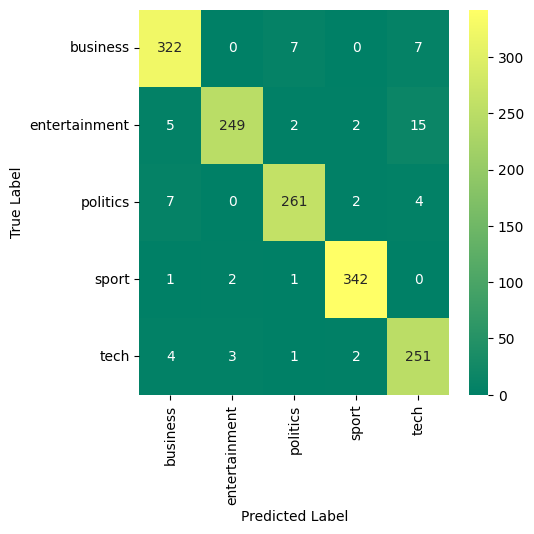

0.9563758389261745


In [32]:
nmf = NMF(n_components=5, random_state=0,
                    init=None, solver='mu', beta_loss='frobenius', max_iter=100)
nmf.fit(X_tfidf)

# predict the training data and get it's label
predict = nmf.transform(X_tfidf)
predict = np.argmax(predict, axis=1)

# change the label of the predict to match the train_label
predict = change_label(predict, train_label)
#plot the confusion matrix
confusion_matrix_heatmap(train_label, predict)
print(accuracy_score(train_label, predict))

---
### 4. Building supervised models and compare with unsupersived learning

We will build a supervised model using the Support Vector Machine (SVM) algorithm. 

**4-1. Split the training data into training and validation sets**

First we will split into the train and test data. Unlike unsupervised learning, we divides the data and valid accuracy of the test data.

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_text, train_label, test_size=0.3, random_state=42)

**4-2 Vectorize X_train, X_valid and X_test using TfidfVectorizer**

In [34]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)

**4-3 Initialize the SVC model and fit it**

In [46]:
model = SVC(C=0.1, kernel='linear', gamma='auto')
model.fit(X_train_tfidf, y_train)

SVC(C=0.1, gamma='auto', kernel='linear')

**4-4. Evaluate the model**

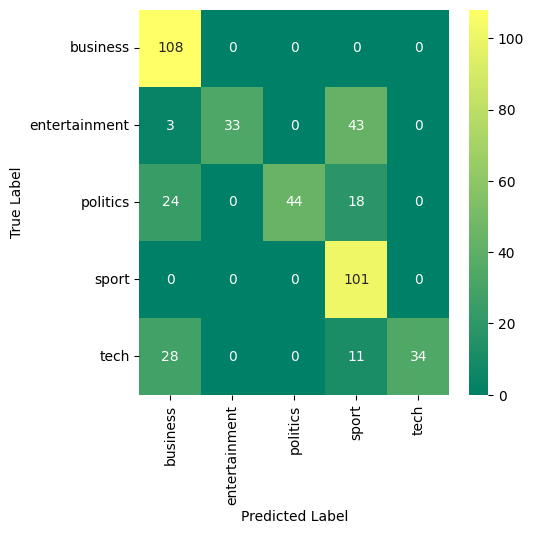

Training accuracy: 0.7190795781399808
Validation accuracy: 0.7158836689038032


In [47]:
y_pred_train = model.predict(X_train_tfidf)
accuracy_train = accuracy_score(y_train, y_pred_train)

y_pred_valid = model.predict(X_valid_tfidf)
accuracy_valid = accuracy_score(y_valid, y_pred_valid)

#plot the confusion matrix
confusion_matrix_heatmap(y_valid, y_pred_valid)
print(f'Training accuracy: {accuracy_train}')
print(f'Validation accuracy: {accuracy_valid}')

**4-5 Find best parameters for the SVC model**

The validation accuracy of the previous model is 0.71. 
The model has a high accuracy but we try to find the best parameters for the SVC model.
What happens if we change the parameters of the SVC model or the volume of the training data?

In [48]:
# itialize the empty dataframe to store the results
result_df = pd.DataFrame(columns=['test_size', 'C', 'kernel', 'gamma', 'accuracy'])


# set the parameters to search
test_size = [0.1, 0.2, 0.3, 0.4, 0.5]
C = [0.1, 1, 10, 100]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto', 0.1, 1, 10]

best_accuracy = 0
best_test_size = None
best_C = None
best_kernel = None
best_gamma = None

# loop through all the parameters and find the best parameters
for size in test_size:
    for c in C:
        for k in kernel:
            for g in gamma:
                X_train, X_valid, y_train, y_valid = train_test_split(
                    train_text, train_label, test_size=size, random_state=42)

                X_train_tfidf = vectorizer.fit_transform(X_train)
                X_valid_tfidf = vectorizer.transform(X_valid)

                model = SVC(C=c, kernel=k, gamma=g)
                model.fit(X_train_tfidf, y_train)

                y_pred_valid = model.predict(X_valid_tfidf)
                accuracy = accuracy_score(y_valid, y_pred_valid)

                # concatenate the results to the results dataframe
                result_df = pd.concat([result_df,
                             pd.DataFrame([[size, c, k, g, accuracy]], 
                            columns=['test_size', 'C', 'kernel', 'gamma', 'accuracy'])])

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_test_size = size
                    best_C = c
                    best_kernel = k
                    best_gamma = g

print(f'Best accuracy: {best_accuracy}')
print(f'Best test_size: {best_test_size}')
print(f'Best C: {best_C}')
print(f'Best kernel: {best_kernel}')
print(f'Best gamma: {best_gamma}')

# results_df sort by column 'accuracy' desending order and print top 5
result_df = result_df.sort_values('accuracy', ascending=False)
print(result_df.head())

Best accuracy: 1.0
Best test_size: 0.1
Best C: 0.1
Best kernel: sigmoid
Best gamma: 10
   test_size      C   kernel  gamma  accuracy
0        0.1    1.0      rbf  scale       1.0
0        0.1   10.0   linear     10       1.0
0        0.1  100.0   linear   auto       1.0
0        0.1    1.0      rbf      1       1.0
0        0.1  100.0  sigmoid  scale       1.0


**4-6 Bild the model from the best parameters**

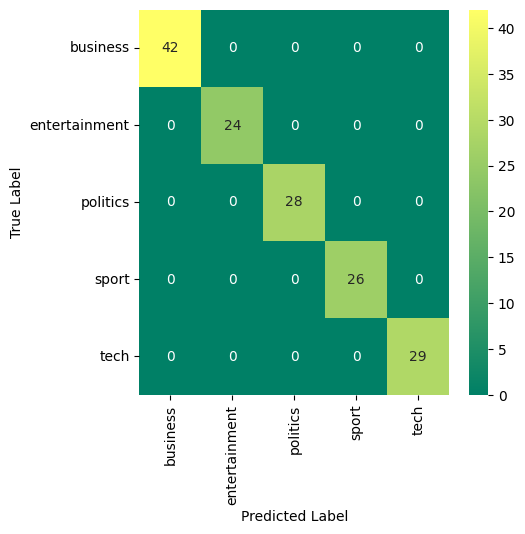

Training accuracy: 1.0
Validation accuracy: 1.0


In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_text, train_label, test_size=0.1, random_state=42)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
model = SVC()
model.fit(X_train_tfidf, y_train)
y_pred_train = model.predict(X_train_tfidf)
accuracy_train = accuracy_score(y_train, y_pred_train)

y_pred_valid = model.predict(X_valid_tfidf)
accuracy_valid = accuracy_score(y_valid, y_pred_valid)

#plot the confusion matrix
confusion_matrix_heatmap(y_valid, y_pred_valid)
print(f'Training accuracy: {accuracy_train}')
print(f'Validation accuracy: {accuracy_valid}')

---
### 5. Compare the results of BBC News test dataset(unlabled) with the result of unsupervised and supervised learning

We build the model best unsupervised and supervised learning model.
So, how both models perform on the test dataset.
The test dataset('cleaned BBC News Test.csv') is unlabeled, we creat a new unsupervised model which has the same parameters as the best unsupervised model.
Next, we predict the test dataset using the unsupervised model and the supervised model and compare the results.

**5-1 The compairson of the results of the NMF and best SVM models**

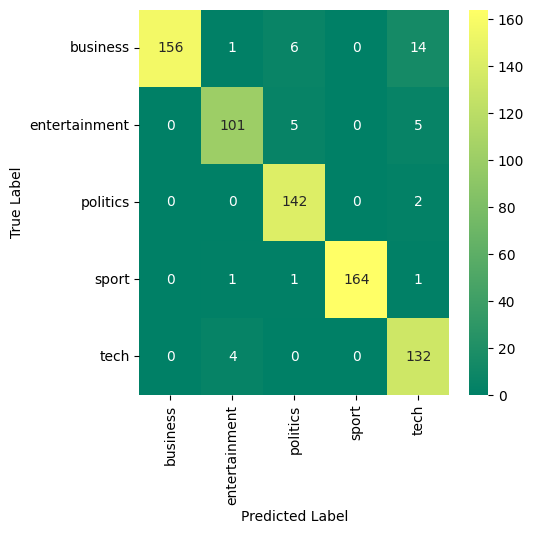

0.9455782312925171


In [50]:
test_text = pd.read_csv('cleaned BBC News Test.csv')['Text']

X_test_tfidf = vectorizer.transform(test_text)
nmf.fit(X_test_tfidf)

# predict the training data and get it's label
predict_unsupervised = nmf.transform(X_test_tfidf)
predict_unsupervised = np.argmax(predict_unsupervised, axis=1)

# predct the test data using SVM
predict_supervised = model.predict(X_test_tfidf)
predict_supervised = pd.Series(predict_supervised)

# change the label of the predict to match the train_label
predict_unsupervised = change_label(predict_unsupervised, predict_supervised)
# plot the confusion matrix
confusion_matrix_heatmap(predict_supervised, predict_unsupervised)
# print the accuracy
print(accuracy_score(predict_supervised, predict_unsupervised))

The accuracy of the model is about 0.94.
We research again the supervised model to find the best **test** parameters.
From the results_df dataframe, we retrive the models which has acuuracies over 0.9.

In [51]:
# get the models which has accuracy over 0.9
best_better = result_df[result_df['accuracy'] > 0.9].reset_index(drop=True)

# research the best parameters again using the best test data set.
best_accuracy = 0
best_test_size = None
best_C = None
best_kernel = None
best_gamma = None

for index, row in best_better.iterrows():
    size = row['test_size']
    c = row['C']
    k = row['kernel']
    g = row['gamma']
    X_train, X_valid, y_train, y_valid = train_test_split(
        train_text, train_label, test_size=size, random_state=42)
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    model = SVC(C=c, kernel=k, gamma=g)
    model.fit(X_train_tfidf, y_train)

    X_test_tfidf = vectorizer.transform(test_text)
    nmf.fit(X_test_tfidf)

    # predict the training data and get it's label
    predict_unsupervised = nmf.transform(X_test_tfidf)
    predict_unsupervised = np.argmax(predict_unsupervised, axis=1)
    # change the label of the predict to match the train_label
    predict_unsupervised = change_label(predict_unsupervised, predict_supervised)
    accuracy = accuracy_score(predict_supervised, predict_unsupervised)

    # update accuracy of best_better dataframe
    best_better.loc[index, 'accuracy'] = accuracy

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_test_size = size
        best_C = c
        best_kernel = k
        best_gamma = g

print(f'Best accuracy: {best_accuracy}')
print(f'Best test_size: {best_test_size}')
print(f'Best C: {best_C}')
print(f'Best kernel: {best_kernel}')
print(f'Best gamma: {best_gamma}')

# results_df sort by column 'accuracy' desending order and print top 5 and tail 5
best_better = best_better.sort_values('accuracy', ascending=False)
print(best_better.head())
print(best_better.tail())

Best accuracy: 0.9482993197278912
Best test_size: 0.5
Best C: 100.0
Best kernel: linear
Best gamma: 10
     test_size     C   kernel  gamma  accuracy
175        0.5  10.0  sigmoid     10  0.948299
160        0.5   0.1  sigmoid     10  0.948299
111        0.5   1.0   linear     10  0.948299
110        0.5  10.0      rbf  scale  0.948299
167        0.5   1.0  sigmoid     10  0.948299
     test_size      C   kernel  gamma  accuracy
101        0.3   10.0      rbf    0.1  0.942857
99         0.3   10.0  sigmoid  scale  0.942857
98         0.3  100.0   linear      1  0.942857
97         0.3  100.0   linear    0.1  0.942857
176        0.4   10.0  sigmoid     10  0.942857


### 6. Conclusion

The supervised learning feature is useful when you want to draw similar conclusions from the data so far. The results will vary depending on the bias and variance of the data and the parameters of the model. Unsupervised learning, on the contrary, may be able to make the desired decision without new classifications or labels. Human judgment can sometimes be wrong. I believe that a combination of supervised and unsupervised learning and human judgment can solve many problems.

### References

1. [Supervised versus unsupervised learning: What's the difference? IBM](https://www.ibm.com/think/topics/supervised-vs-unsupervised-learning#)

2. [ML | Classification vs Clustering - GeeksforGeeks](https://www.geeksforgeeks.org/ml-classification-vs-clustering/)
3. [自然言語処理の基礎「TF-IDF」を自分なりにまとめてみた(Japanese wedsite about TF-IDF)](https://nanjamonja.net/archives/727)